In [1]:
import pandas as pd
import random
from time import sleep
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
import numpy as np
import nltk
import os
from sklearn import datasets
import pickle
from nltk.tokenize import word_tokenize
from sklearn.decomposition import NMF, TruncatedSVD
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.neighbors import NearestNeighbors
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.linear_model import RidgeCV
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, roc_curve, auc, fbeta_score
from sklearn.model_selection import learning_curve, KFold, GridSearchCV, cross_val_score
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.dummy import DummyClassifier
from collections import Counter
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction import text
from sklearn.preprocessing import normalize
import re
from unidecode import unidecode

import matplotlib.style as style
%matplotlib inline
plt.style.use('ggplot')

/Users/brendenrossin/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
with open('data/cleaned_df.pkl', 'rb') as picklefile:
    df = pickle.load(picklefile)

In [3]:
df.head()

,song_owner,song_title,song_element,verse,artist
0,Childish Gambino,This Is America,[Bridge: Childish Gambino & Young Thug],"We just wanna party, Party just for you, We ju...",Childish Gambino
1,Childish Gambino,This Is America,[Chorus: Childish Gambino],"This is America, Don't catch you slippin' now,...",Childish Gambino
2,Childish Gambino,This Is America,"[Verse 1: Childish Gambino, Blocboy JB, Slim J...","This is America (skrrt, skrrt, woo), Don't cat...",Childish Gambino
3,Childish Gambino,This Is America,[Refrain: Choir & Childish Gambino],"Ooh-ooh-ooh-ooh-ooh, tell somebody, You go tel...",Childish Gambino
4,Childish Gambino,This Is America,"[Chorus: Childish Gambino, Slim Jxmmi & Young ...","This is America (woo, ayy), Don't catch you sl...",Childish Gambino


In [4]:
model_df = df.copy()

model_df = model_df[model_df['artist'] == 'Kanye West']

In [5]:
model_df['verse_words'] = model_df['verse'].copy()
model_df['verse_words'] = model_df['verse_words'].str.lower()
model_df['verse_words'] = model_df['verse_words'].apply(lambda x: x.replace(',',''))
model_df['verse_words'] = model_df['verse_words'].apply(lambda x: x.split(' '))

In [6]:
model_df.head()

,song_owner,song_title,song_element,verse,artist,verse_words
913,Chance The Rapper,All We Got,[Outro: Kanye West & Chicago Children's Choir],"We know, we know we got it, We know, we know w...",Kanye West,"[we, know, we, know, we, got, it, we, know, we..."
1281,Chance The Rapper,All We Got,[Outro: Kanye West & Chicago Children's Choir],"We know, we know we got it, We know, we know w...",Kanye West,"[we, know, we, know, we, got, it, we, know, we..."
1746,Drake,Pop Style (Single Version),[Verse 2: Kanye West],"They like, ""Pablo—"", ""Why are all the windows ...",Kanye West,"[they, like, ""pablo—"", ""why, are, all, the, wi..."
1931,Drake,Glow,[Chorus: Kanye West],"Watch out for me, I'm bound to glow, You bette...",Kanye West,"[watch, out, for, me, i'm, bound, to, glow, yo..."
1932,Drake,Glow,[Verse 1: Kanye West],"Your boy all glowed up, Every time we touch do...",Kanye West,"[your, boy, all, glowed, up, every, time, we, ..."


In [7]:
from nltk.tokenize import word_tokenize
model_df['tokenize_verse'] = model_df['verse'].copy()
model_df['tokenize_verse'] = model_df['tokenize_verse'].str.lower()
model_df['tokenize_verse'] = model_df['tokenize_verse'].apply(lambda x: word_tokenize(x))

In [8]:
model_df['verse'] = model_df['verse'].str.lower()
model_df['verse'] = model_df['verse'].apply(lambda x: x.replace("'",''))
model_df['verse'] = model_df['verse'].apply(lambda x: "".join([c if c.isalnum() else " " for c in x ]))
model_df['verse'] = model_df['verse'].apply(lambda x: x.replace('  ',' '))

In [9]:
stopwords = ["yeah", "uh", "huh", "aw", "oh", "la", "ayy",
            "na", "ha", "ay", "skrrt",
            "em", "bla", "woo", "wu", "ya", "wala", "woop", "wrarrr", "ooh",
            "ba", "duh", "du", "1", "2", "3", "4" ,"5" ,"6", "7", "8", "9", "0"]

for index, row in model_df.iterrows():
    querywords = row['verse'].split()

    resultwords  = [word for word in querywords if word.lower() not in stopwords]
    row['verse'] = ' '.join(resultwords)

model_df.verse[:5]

913     we know we know we got it we know we know we g...
1281    we know we know we got it we know we know we g...
1746    they like pablo why are all the windows tinted...
1931    watch out for me im bound to glow you better w...
1932    your boy all glowed up every time we touch dow...
Name: verse, dtype: object

In [10]:
verses = list(model_df.verse.values)

In [11]:
verses[:10]

['we know we know we got it we know we know we got it we know we know we got it we know we know we got it music we know we know we got it we know we know we got it we know we know we got it we know we know we got it music music is all we got',
 'we know we know we got it we know we know we got it we know we know we got it we know we know we got it music we know we know we got it we know we know we got it we know we know we got it we know we know we got it music music is all we got',
 'they like pablo why are all the windows tinted on your tahoe why do you know every single bitch that i know why cant you just shut your mouth and take the high road fuck if i know thats that chicago south south side thats the motto cop a crib and spend ten million on remodel take the devils out my life and preach the gospel cause i know we went way way past the line of scrimmage throne is back up in it in the field like emmitt yall get so offended i be blacking out i aint backing out jay about his busines

In [12]:
all_verses_all_rappers = ','.join(verses)

all_verses_all_rappers[:100]

'we know we know we got it we know we know we got it we know we know we got it we know we know we got'

In [13]:
file = all_verses_all_rappers

In [14]:
# Read in text and change unicode characters to ASCII
import unidecode
import string
import random
import re

all_characters = string.printable
n_characters = len(all_characters)

file_len = len(file)
print(f'file_len = {file_len}')

file_len = 692640


In [15]:
chunk_len = 400

def random_chunk():
    start_index = random.randint(0, file_len - chunk_len)
    end_index = start_index + chunk_len + 1
    return file[start_index:end_index]

print(random_chunk())

 name i know the game i know the game and i don t wanna hear all those excuses they all the same we should both be ashamed cause we know the game,i never go soft i always go raw like im tryna have six kids pablo love the kids pablo love his bitch pablo loved his mom i jus,she under the influence keep doin what you been doin keep doin what you been doin keep doin what you been doin she under the inf


In [16]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        
        self.encoder = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers)
        self.decoder = nn.Linear(hidden_size, output_size)
        
    def forward(self, input, hidden):
        output = self.encoder(input.view(1, -1))
        output, hidden = self.gru(output.view(1, 1, -1), hidden)
        output = self.decoder(output.view(1, -1))
        
        return output, hidden
    
    def init_hidden(self):
        return Variable(torch.randn(self.n_layers, 1, self.hidden_size))

In [17]:
def char2tensor(string):
    tensor = torch.zeros(len(string)).long()
    for char in range(len(string)):
        if string[char] in all_characters:
            tensor[char] = all_characters.index(string[char])
        else:
            tensor[char] = 94 #predict space if character unknown
        
    return Variable(tensor)

# Let's see it in action.
print(char2tensor('Metis0123abczABC'))

tensor([48, 14, 29, 18, 28,  0,  1,  2,  3, 10, 11, 12, 35, 36, 37, 38])


In [18]:
def random_training_set():
    chunk = random_chunk()
    inp = char2tensor(chunk[:-1])
    target = char2tensor(chunk[1:])
    return inp, target

In [19]:
def evaluate(model, prime_str='A', predict_len=100, temperature=0.8):
    
    hidden = model.init_hidden()
    prime_input = char2tensor(prime_str)
    predicted = prime_str
    
    # use priming string to build up hidden state
    
    for p in range(len(prime_str) - 1):
        _, hidden = model(prime_input[p], hidden)
    inp = prime_input[-1]
    
    for p in range(predict_len):
        output, hidden = model(inp, hidden)
        
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]
        
        # Add predicted character to string and use as next input
        predicted_char = all_characters[top_i]
        predicted += predicted_char
        inp = char2tensor(predicted_char)
        
    return predicted

In [20]:
# helper function
import time, math

def time_since(since):
    s = time.time() - since
    m = math.floor(s/60)
    s -= m*60
    return '%dm %ds' % (m, s)

In [21]:
# The actual training part
def train(inp, target):
    hidden = model.init_hidden()
    model.zero_grad()
    loss = 0

    for char in range(chunk_len):
        output, hidden = model(inp[char], hidden)
        loss += criterion(output, target[char].unsqueeze(0))

    loss.backward()
    model_optimizer.step()

    return loss.data.item() / chunk_len

In [22]:
# parameters
n_epochs = 1000
print_every = 100
plot_every = 10
hidden_size = 256
n_layers = 2
learning_rate = 0.001

# model declaration
model = RNN(n_characters, hidden_size, n_characters, n_layers)
model_optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
loss_avg = 0

for epoch in range(1, n_epochs + 1):
    loss = train(*random_training_set())       
    loss_avg += loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss))
        print(evaluate(model, 'A ', 100), '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

 10s (100 10%) 2.1458]
A the a site men gee it is fot your go dong set so dond to mse ow an ang amy you gowk a ok thle is bor 

 24s (200 20%) 1.8109]
A con like man the the wand the buta a ica mome at the you ligas stit olid you ryeen when sthe risis t 

 38s (300 30%) 1.7677]
A mack exep i had the remive cant go see me rundiy the way on the toblie me me im the you got the umli 

 54s (400 40%) 1.6278]
A i ill that mare gveres over the uses drout the bout will this and be houcking say is back whater you 

 14s (500 50%) 1.7056]
A why im as what that beat so ive nigga i krold thin int really in the ride and im i its i dont can he 

 31s (600 60%) 1.5662]
A the so at got man i see my compave tell releas and brout just on i got day like tije what want you k 

 44s (700 70%) 1.7960]
A times you she kids her micher at the modinfer thiss thies suple to to pool doum me the be all im got 

 51s (800 80%) 1.6438]
A ice amens on more off me this say this the pain to me in t get that bitgo bough

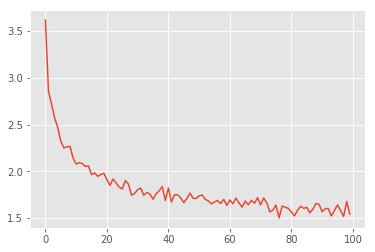

In [23]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(all_losses)

In [24]:
with open('models/kanye_rnn_generator.pkl', 'wb') as picklefile:
    pickle.dump(model, picklefile)

In [25]:
# Evaluate model from this notebook
print(evaluate(model, 'To be or not to be: ', predict_len=200, temperature=0.5))

To be or not to be: a part the pict all a best the but the promin with the like and the runnin the fight i all the way and to get a ticked to the like the real the coutt the whole girl that the trine the the right cant i


In [26]:
# Evaluate model from this notebook
print(evaluate(model, 'I miss you girl come back ', predict_len=200, temperature=0.5))

I miss you girl come back that no i get me off my in the crack i got the reming i do more i m me the clus i got the rack i was to what me that i got the crack when it that it that in that i want the money that when the man the


In [27]:
# Evaluate model from this notebook
print(evaluate(model, "Started from the bottom", predict_len=200, temperature=0.4))

Started from the bottom the recause to me i know it my could off the dont to make that the face the like the company what you got a compan the man the chance the fan that it in the real the ord that that i get so him off th


In [28]:
# Evaluate model from this notebook
print(evaluate(model, "I'm the realest rapper alive", predict_len=200, temperature=0.4))

I'm the realest rapper alive that i want the channa like the compan you to get a here the rap roc that in the come that i want the race and she can this the rait this her cant right the cray i want the dont not hard a beat the c


In [29]:
# Evaluate model from this notebook
print(evaluate(model, "Smoke a lot of weed", predict_len=200, temperature=0.4))

Smoke a lot of weed to the roc a off the contion the chance the said that the race i all that the cray nigga that i want a fine she down that to the classin with the part the chance the race the should off the chance sh


In [30]:
# Evaluate model from this notebook
print(evaluate(model, "Baby come", predict_len=200, temperature=0.4))

Baby come the still like the something im something something me gon to get off you to her the stop that i want the said that i was i say what the ordiat the start they cant to say with off you that that the w
